In [1]:
from icevision.all import *
import icedata
from PIL import Image
from icevision_detector import *

In [2]:
import gradio as gr

---
# Set config and load model

In [3]:
IMG_SIZE = 512

In [4]:
class_map = ClassMap([
    'background', 'short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear', 
    'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress', 'vest_dress', 
    'sling_dress'
])

In [5]:
light_model = EffDetModel.load_from_checkpoint(checkpoint_path='checkpoints/d3_0_576.ckpt', num_classes=14,
                                               img_size=IMG_SIZE, model_name="tf_efficientdet_d3",
                                              )

<AxesSubplot:>

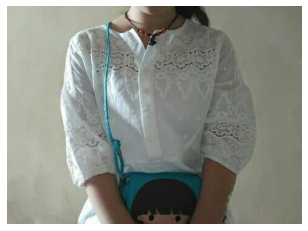

In [6]:
img = open_img('assets/sample_image.jpg')
show_img(img)

---
# Run test inference

In [7]:
resize_tfm = tfms.A.Resize(always_apply=True, p=1, height=IMG_SIZE, width=IMG_SIZE, interpolation=1)

In [8]:
infer_tfms = tfms.A.Adapter([resize_tfm, tfms.A.Normalize()])
infer_ds = Dataset.from_images([img], infer_tfms)
infer_dl = efficientdet.infer_dl(infer_ds, batch_size=1)

In [9]:
samples, preds = efficientdet.predict_dl(
    model=light_model, 
    infer_dl=infer_dl, 
    device='cpu', 
    detection_threshold=0.4
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
def rescale_prediction(prediction, original_image, transformed_image):
    transformed_h, transformed_w, c = transformed_image.shape
    original_h, original_w, c = original_image.shape
    rescaled_prediction = deepcopy(prediction)
    
    # TODO: change to write directly in loop without appending
    scaled_bboxes = []
    for bbox in rescaled_prediction['bboxes']:
        (xc, yc, w, h) = bbox.relative_xcycwh(transformed_w, transformed_h)
        scaled_bbox = BBox.from_relative_xcycwh(xc, yc, w, h, original_w, original_h)
        scaled_bboxes.append(scaled_bbox)
    rescaled_prediction['bboxes'] = scaled_bboxes
    
    return rescaled_prediction

In [11]:
transformed_image = samples[0]['img']
transformed_prediction = draw_pred(
    img=transformed_image, 
    pred=preds[0], 
    class_map=class_map, 
    denormalize_fn=denormalize_imagenet, 
)

In [12]:
original_image = infer_ds.records[0]['img']
original_prediction = draw_pred(
    img=normalize_imagenet(original_image), 
    pred=rescale_prediction(preds[0], original_image, transformed_image), 
    class_map=class_map, 
    denormalize_fn=denormalize_imagenet, 
)

---
# show results

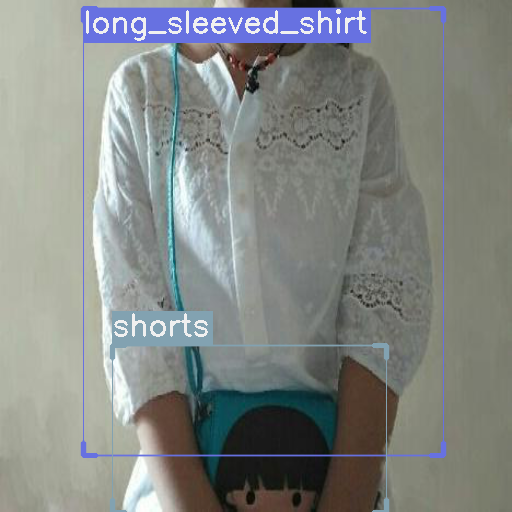

In [13]:
Image.fromarray(transformed_prediction)

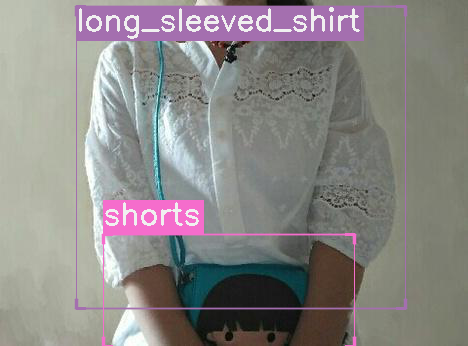

In [14]:
Image.fromarray(original_prediction)

---
# define helper functions for gradio

In [15]:
def my_predict(
    model, image, detection_threshold: float = 0.5, mask_threshold: float = 0.5
):
    resize =  [tfms.A.Resize(always_apply=True, p=1, height=512, width=512, interpolation=1)]
    tfms_ = tfms.A.Adapter([*resize, tfms.A.Normalize()])
    # Whenever you have images in memory (numpy arrays) you can use `Dataset.from_images`
    infer_ds = Dataset.from_images([image], tfms_)

    batch, samples = efficientdet.build_infer_batch(infer_ds)
    preds = efficientdet.predict(
        model=model,
        batch=batch,
        detection_threshold=detection_threshold
    )
    return samples[0]["img"], preds[0]

In [16]:
def my_show_original_preds(input_image, detection_threshold):
    if detection_threshold==0: detection_threshold=0.01

    img, pred = my_predict(model=light_model, image=input_image, detection_threshold=detection_threshold)
    
    rescaled_pred = rescale_prediction(pred, input_image, img)
    img = draw_pred(
        img=normalize_imagenet(input_image), 
        pred=rescaled_pred, 
        class_map=class_map, 
        denormalize_fn=denormalize_imagenet, 
    )
    
    img = Image.fromarray(img)
    # print("Output Image: ", img.size, type(img))
    return img

In [17]:
# display_chkbox = gr.inputs.CheckboxGroup(["Label", "BBox"], label="Display")
detection_threshold_slider = gr.inputs.Slider(minimum=0.0, maximum=1.0, step=0.1, default=0.5, label="Detection Threshold")

outputs = gr.outputs.Image(type="pil")

gr_interface = gr.Interface(
    fn=my_show_original_preds, 
    inputs=["image", detection_threshold_slider], 
    outputs=outputs, 
    title='fashion detector',
    description = [
        'Object Detection as a part of recruitment task for DeepBrand. '
        'Architecture based on EfficientDetD3 model, trained on deepfashion2 dataset. '
        'Author: Pawel Potrykus https://github.com/potipot '
    ]
)
gr_interface.launch(inline=False, share=True, debug=True)


Running locally at: http://127.0.0.1:7860/
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://27856.gradio.app
Tip: Add interpretation to your model by simply adding `interpretation="default"` to `Interface()`


KeyboardInterrupt: 